In [ ]:
# Install Qiskit if you haven't already
!pip install qiskit
!pip install qiskit-machine-learning==0.6.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.7
    Uninstalling dill-0.3.7:
      Successfully uninstalled dill-0.3.7
  Attempting uninstall: qiskit-machine-learning
    Found existing installation: qiskit-machine-learning 0.7.0
    Uninstalling qiskit-machine-learning-0.7.0:
      Successfully uninstalled qiskit-machine-learning-0.7.0


# Wine Data Classification


In [ ]:

# Import necessary modules from Qiskit
from qiskit import Aer, QuantumCircuit, transpile, assemble
from qiskit.circuit import Parameter
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data
# from qiskit_machine_learning.utils import map_label_to_class_name

In [ ]:
from sklearn.datasets import load_wine

wine_data = load_wine()

In [ ]:
print(wine_data.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

In [ ]:
features = wine_data.data
labels = wine_data.target

In [ ]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

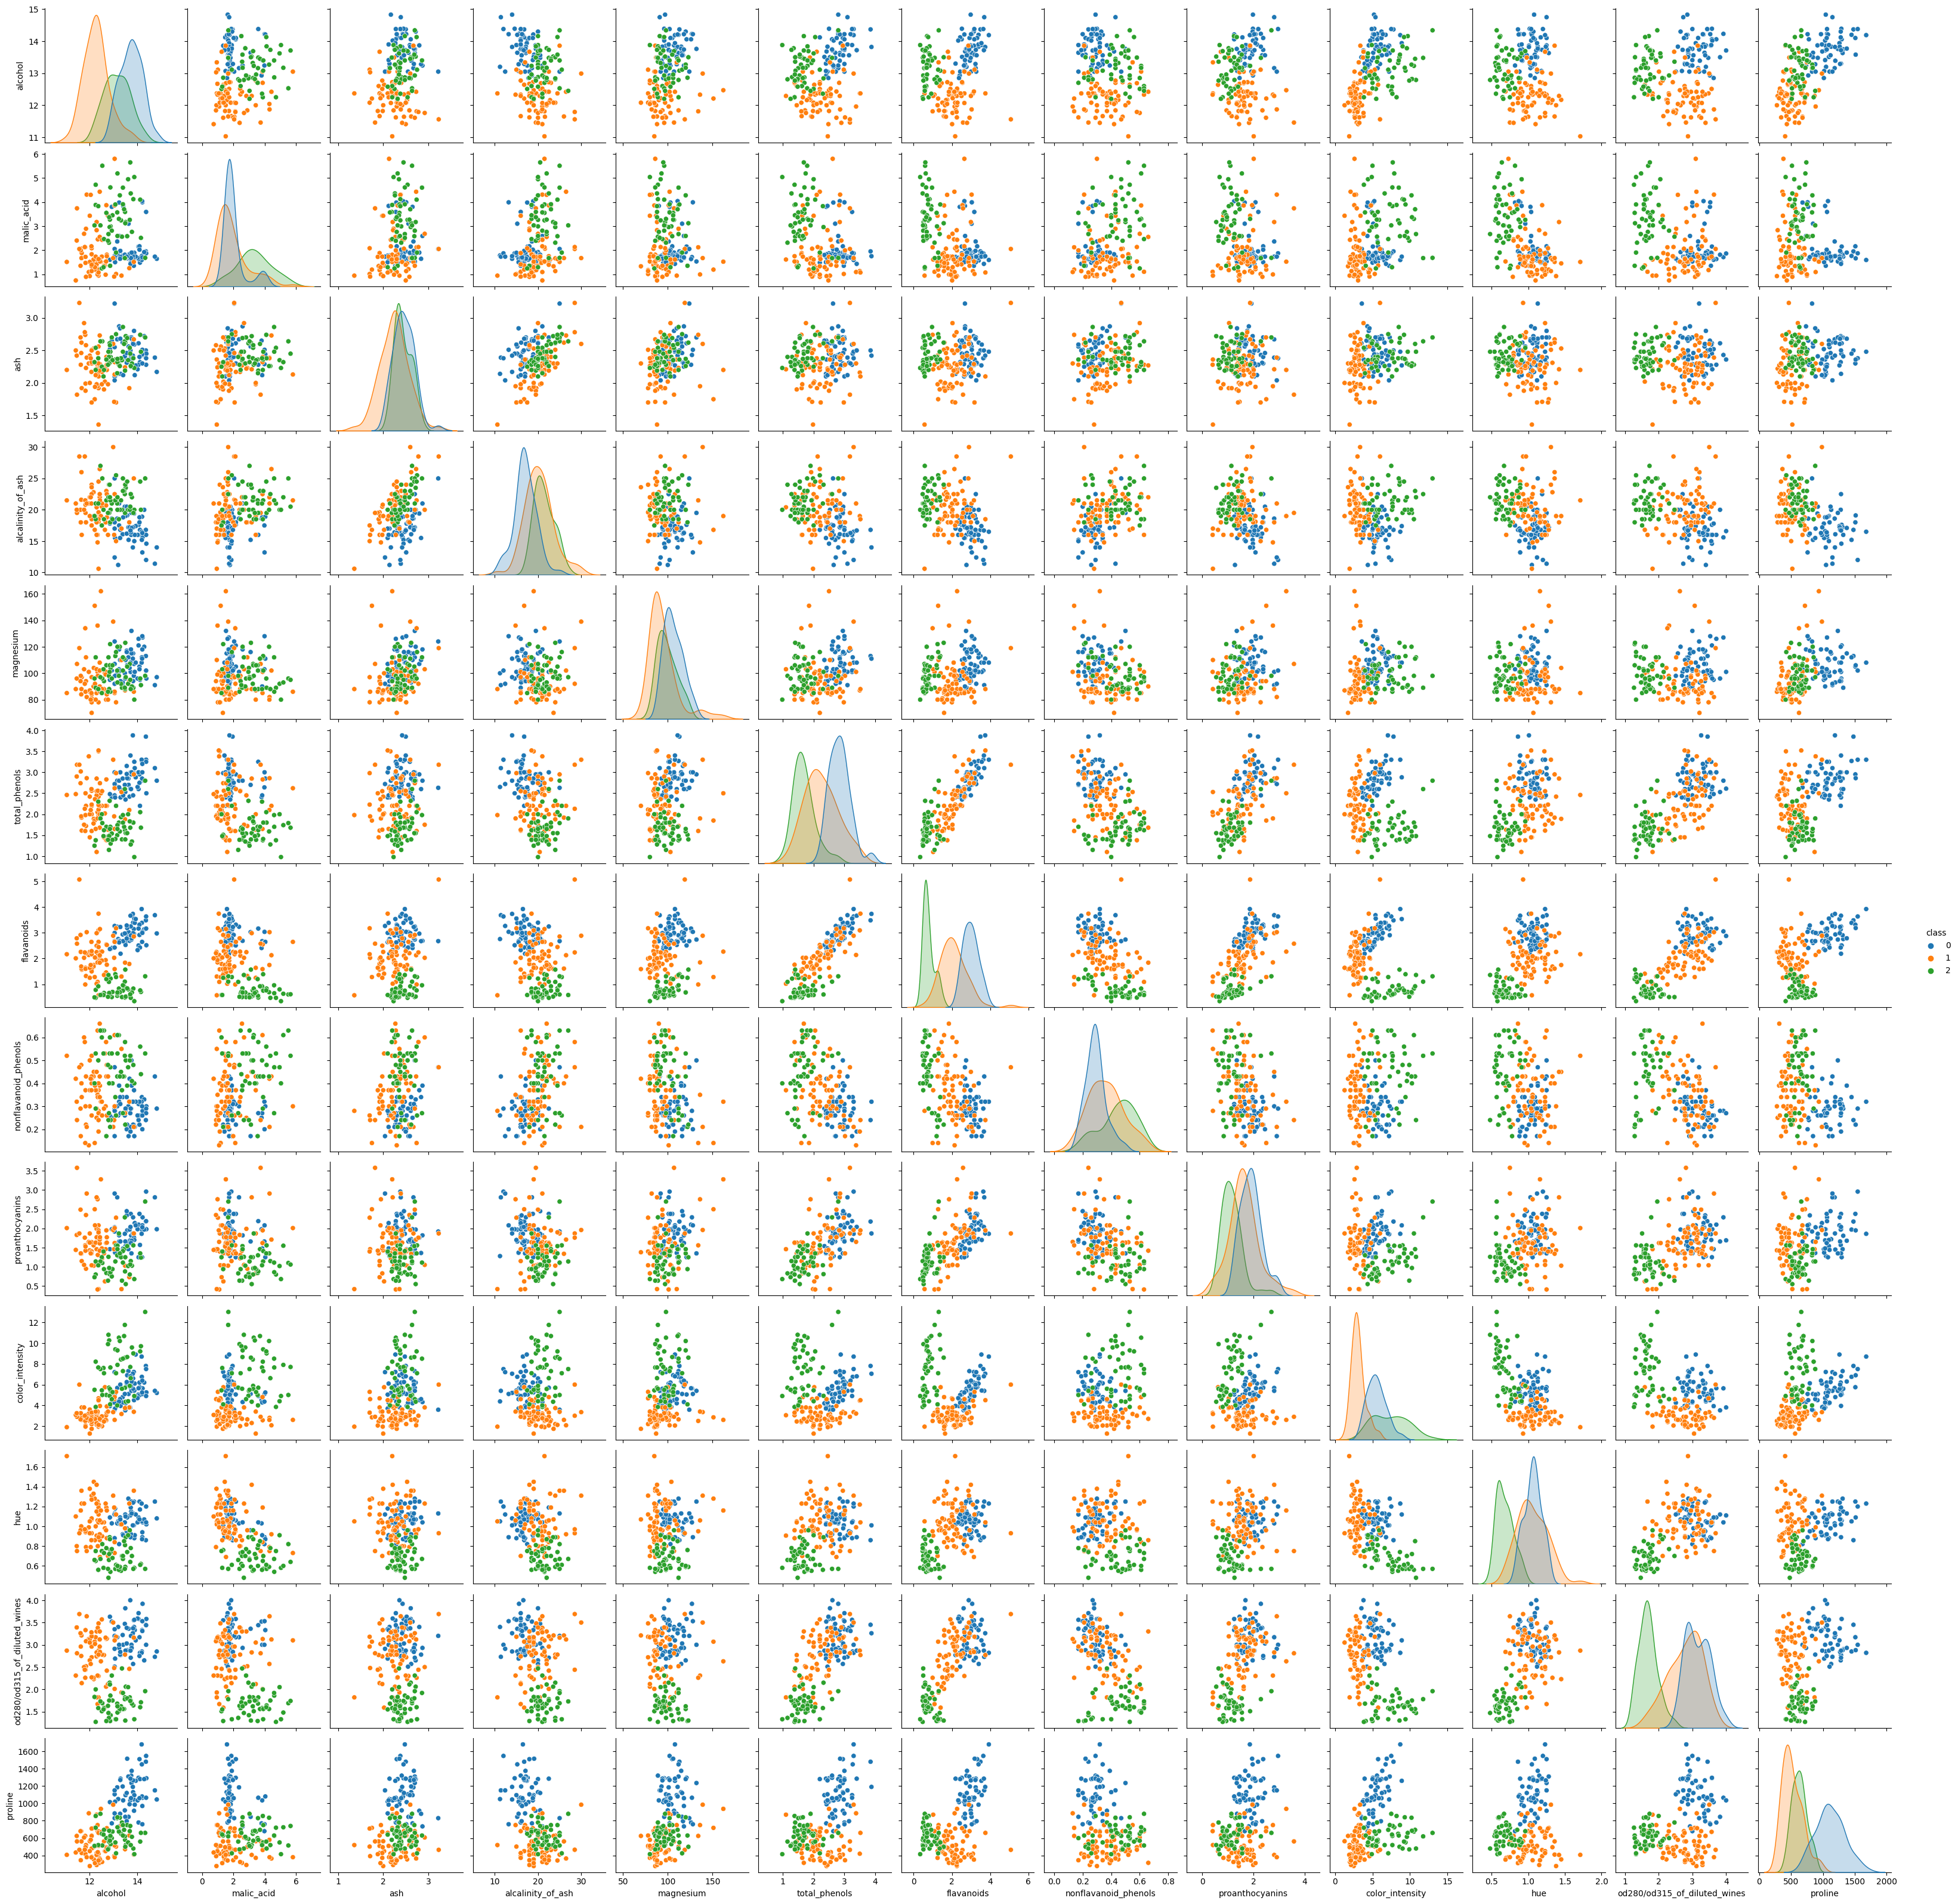

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)
df["class"] = pd.Series(wine_data.target)

sns.pairplot(df, hue="class", palette="tab10")

In [ ]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

<ipython-input-48-bba459bafe92>:4: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 123
<ipython-input-48-bba459bafe92>:6: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  features, labels, train_size=0.8

In [ ]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [ ]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 1.00
Classical SVC on the test dataset:     0.97


In [ ]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose()

In [ ]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose()

In [ ]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [ ]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

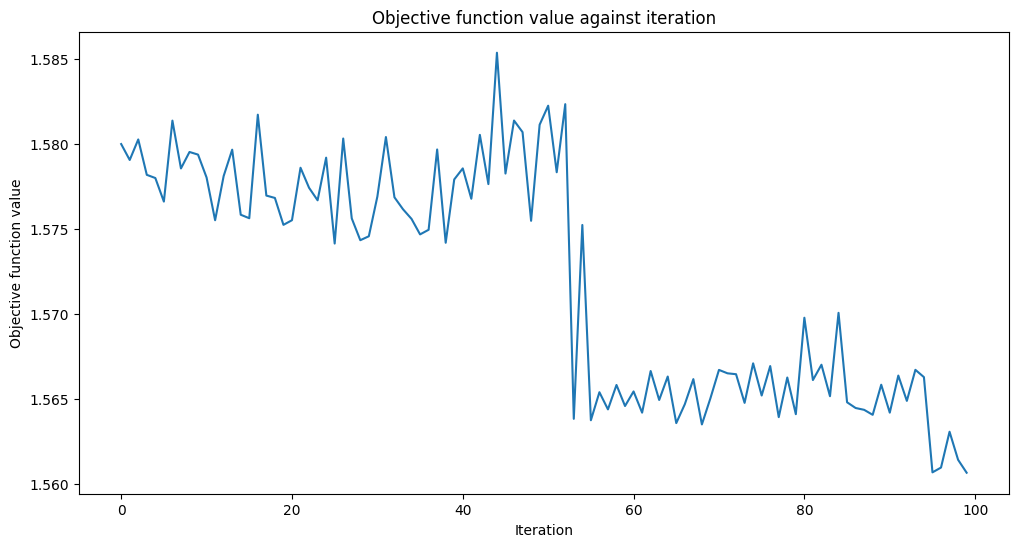

Training time: 4782 seconds


In [ ]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.59
Quantum VQC on the test dataset:     0.44


## Feature Reduction from 13 to 2

<Axes: >

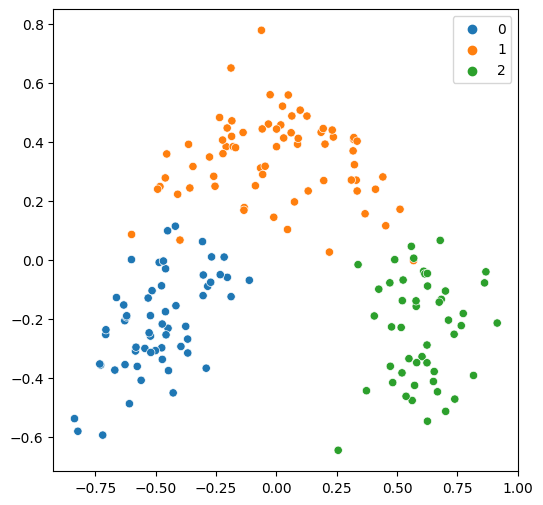

In [ ]:
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


<ipython-input-18-0d5808efbf02>:2: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  features, labels, train_size=0.8, random_state=algorithm_globals.random_seed


### RealAplitude Ansatz Result

In [ ]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

In [ ]:
optimizer = COBYLA(maxiter=100)


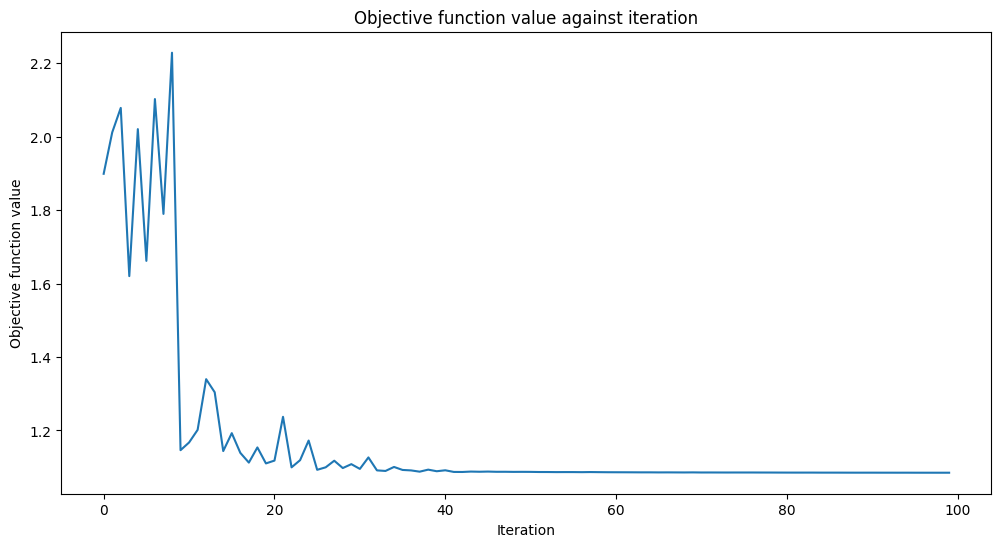

Training time: 76 seconds


In [ ]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.48
Quantum VQC on the test dataset using RealAmplitudes:     0.39


### EfficientSU2 Ansatz Result

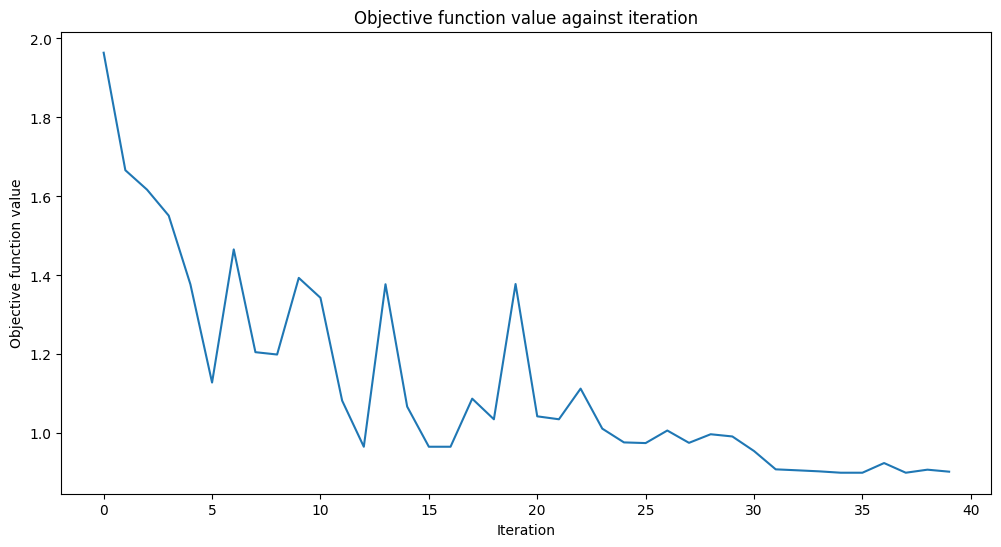

Training time: 38 seconds


In [ ]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=40)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.70
Quantum VQC on the test dataset using EfficientSU2:     0.61


## Feature Reduction to 8

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

<Axes: >

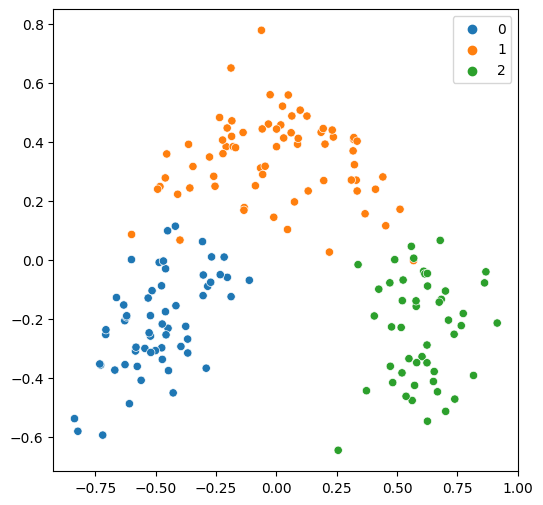

In [ ]:
from sklearn.decomposition import PCA

features = PCA(n_components=8).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c8 = svc.score(train_features, train_labels)
test_score_c8 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c8:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c8:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


<ipython-input-63-c2b0f45ab7f6>:2: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  features, labels, train_size=0.8, random_state=algorithm_globals.random_seed


### Solution by Building Quantum Convolutional Neural Network

In [ ]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)

In [ ]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")

In [ ]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)

In [ ]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

In [ ]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features)

In [ ]:

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

qnn = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)


In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

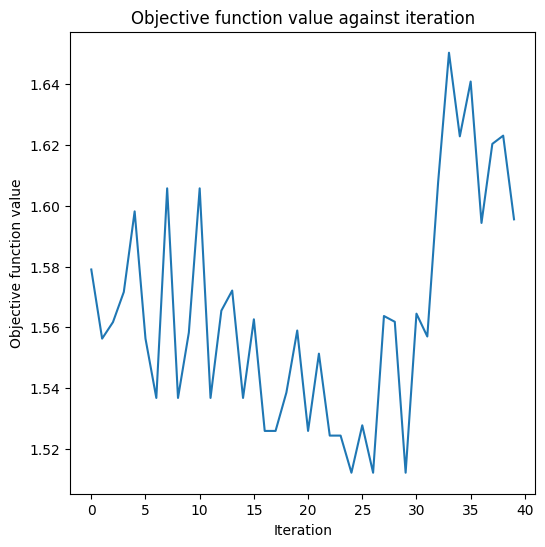

Training time: 291 seconds


In [ ]:
# clear objective value history
objective_func_vals = []

start = time.time()
qnn.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q2_qcon = qnn.score(train_features, train_labels)
test_score_q2_qcon = qnn.score(test_features, test_labels)

In [ ]:
print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_qcon:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_qcon:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.51
Quantum VQC on the test dataset using EfficientSU2:     0.56


## Solution by Hybrid Classical-Quantum Neural Network

In [ ]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

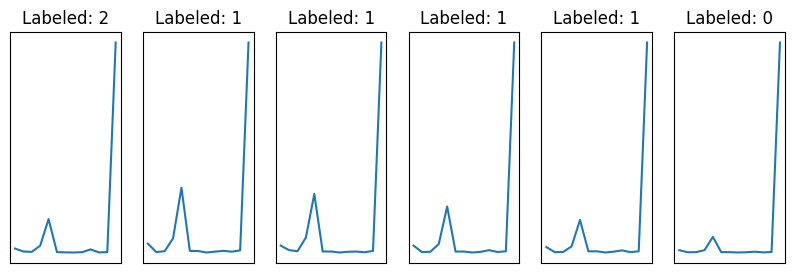

In [ ]:
import torch
from torch.utils.data import Dataset
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
import numpy as np

class WineDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Load wine data
wine = load_wine()
n_samples = 100
idx = np.concatenate((np.where(wine.target == 0)[0][:n_samples],
                      np.where(wine.target == 1)[0][:n_samples],
                      np.where(wine.target == 2)[0][:n_samples]))

# Create dataset
wine_data = WineDataset(wine.data[idx], wine.target[idx])

# Create DataLoader
train_loader = torch.utils.data.DataLoader(wine_data, batch_size=1, shuffle=True)
data_iter = iter(train_loader)

# Showing samples
n_samples_show = 6
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

for _ in range(n_samples_show):
    images, targets = next(data_iter)
    ax = axes[_]
    ax.plot(images[0].numpy())
    ax.set_title(f"Labeled: {targets.item()}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:

test_idx = np.concatenate((np.where(wine.target == 0)[0][:50],
                           np.where(wine.target == 1)[0][:50],
                           np.where(wine.target == 2)[0][:50]))


test_data = WineDataset(wine.data[test_idx], wine.target[test_idx])

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)


In [ ]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [ ]:
# Define torch NN module


class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

In [ ]:

import torch
import torch.nn as nn
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit import QuantumCircuit

class WineNet(Module):
    def __init__(self, qnn):
        super(WineNet, self).__init__()

        self.fc1 = Linear(X.shape[1], 64)  # X.shape[1]
        self.fc2 = Linear(64, 2)

        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 3)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = self.fc2(x)


        x = self.qnn(x)


        x = self.fc3(x)
        return F.softmax(x, dim=1)


model4 = WineNet(qnn4)

In [ ]:
model4 = WineNet(qnn4)

In [ ]:


from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn

wine_data = load_wine()
X = wine_data.data
y = wine_data.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()


# Define optimizer and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [ ]:
# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: 1.1215
Training [20%]	Loss: 1.1218
Training [30%]	Loss: 1.1173
Training [40%]	Loss: 1.1205
Training [50%]	Loss: 1.1196
Training [60%]	Loss: 1.1213
Training [70%]	Loss: 1.1187
Training [80%]	Loss: 1.1188
Training [90%]	Loss: 1.1250
Training [100%]	Loss: 1.1209


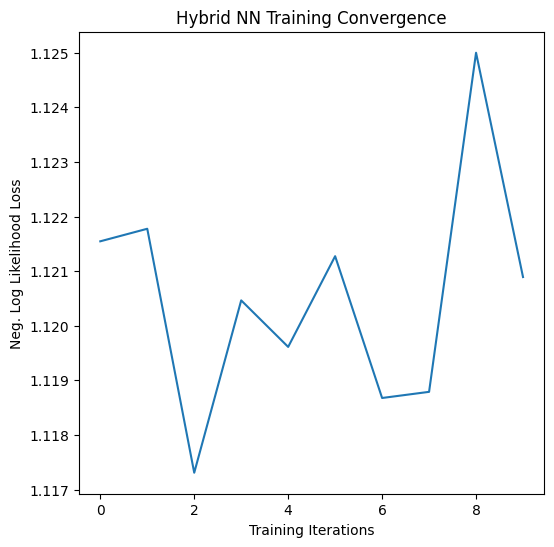

In [ ]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [ ]:
torch.save(model4.state_dict(), "model4.pt")


In [ ]:
qnn5 = create_qnn()
model5 = WineNet(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

<All keys matched successfully>

In [ ]:


model5.eval()  # set model to evaluation mode
total_loss = []  # Initialize total_loss list
total_samples = len(test_loader.dataset)  # Total number of samples in the test set

with no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    accuracy = 100. * correct / total_samples
    avg_loss = sum(total_loss) / len(total_loss)
    print("Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(avg_loss, accuracy))


Performance on test data:
	Loss: 1.0804
	Accuracy: 38.9%


# MNIST Classification

In [ ]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 89112133.07it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 11685866.66it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27266241.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14988614.29it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



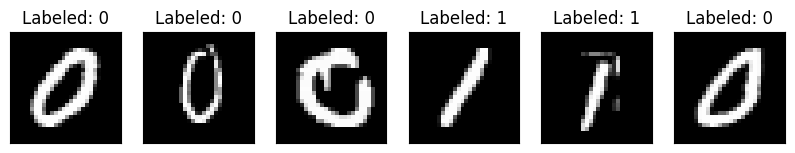

In [ ]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [ ]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [ ]:
# Define torch NN module


class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

qnn6 = create_qnn()
model6 = Net(qnn6)

In [ ]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model6.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model6(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -0.5919
Training [20%]	Loss: -1.0720
Training [30%]	Loss: -1.5270
Training [40%]	Loss: -1.8174
Training [50%]	Loss: -2.0362
Training [60%]	Loss: -2.2738
Training [70%]	Loss: -2.5326
Training [80%]	Loss: -2.7389
Training [90%]	Loss: -2.9562
Training [100%]	Loss: -3.1808


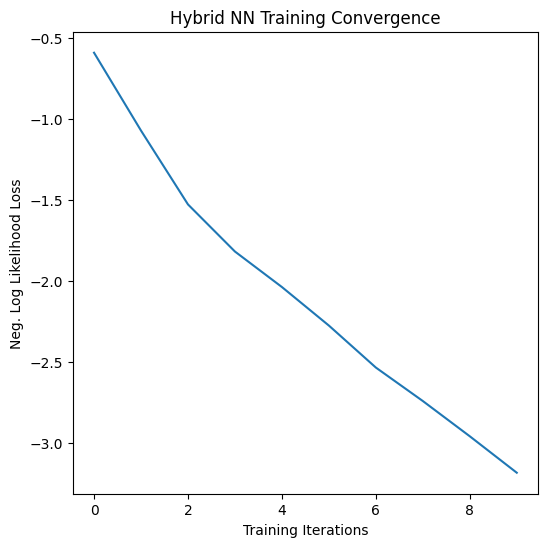

In [ ]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [ ]:
torch.save(model6.state_dict(), "model6.pt")


In [ ]:
qnn7 = create_qnn()
model7 = Net(qnn7)
model7.load_state_dict(torch.load("model6.pt"))

<All keys matched successfully>

In [ ]:
model7.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model7(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: -3.2195
	Accuracy: 100.0%
